In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as kr
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import optimizers
import logging
logging.getLogger('tensorflow').disabled = True

## 定義Dobot順向運動學

In [49]:
def dobot_forword_kine(joints):

    if joints.ndim == 1:
        joints = np.expand_dims(joints, 0)

    q1 = joints[:, 0:1]
    q2 = joints[:, 1:2]
    q3 = joints[:, 2:3]

    a2 = 135
    a3 = 147
    a4 = 61

    C1 = np.cos(q1)
    C2 = np.cos(q2)
    C23 = np.cos(q2 + q3)
    S1 = np.sin(q1)
    S2 = np.sin(q2)
    S23 = np.sin(q2 + q3)

    dx = C1 * (a3 * C23 + a2 * C2 + a4)
    dy = S1 * (a3 * C23 + a2 * C2 + a4)
    dz = -a2 * S2 - a3 * S23

    Point = np.hstack([dx, dy, dz])
    return Point

## 產生訓練資料與測試資料


In [50]:
def gen_data(Train_num):
    joint_1 = (-np.pi / 2) + np.pi * np.random.rand(Train_num, 1)
    joint_2 = (-85 * np.pi / 180) + (85 * np.pi / 180) * np.random.rand(Train_num, 1)
    joint_3 = (-10 * np.pi / 180) + (105 * np.pi / 180) * np.random.rand(Train_num, 1)
    joints = np.hstack((joint_1, joint_2, joint_3))
    points = dobot_forword_kine(joints)
    return points, joints

In [51]:
x_train, y_train = gen_data(150000)
x_test, y_test = gen_data(500)

## 建立模型

In [52]:
num = 32  # 神經元數
lys = 11  # 隱藏層數
is_normalize = True

#設定輸入層
model = Sequential()
model.add(Dense(units=num, input_dim=3, activation='relu'))
if is_normalize:
    model.add(BatchNormalization())

#設定隱藏層
for i in range(0, lys):
    model.add(Dense(units=num, activation='relu'))
    if is_normalize:
        model.add(BatchNormalization())

#設定輸出層
model.add(Dense(units=3, activation='linear'))
if is_normalize:
    model.add(BatchNormalization())

## 訓練

### 可自訂損失函數

In [53]:
def euclidean_distance(y_true, y_pred):
        return kr.sqrt(kr.sum(kr.square(y_true - y_pred)))

### 訓練

In [65]:
lr = 0.001  # 學習率
epochs = 500  # 代數

loss_fnc = 'mse'  # 可選擇 'mae', 'mse', 'msle', 'categorical_crossentropy' 或自訂損失函數等...
# 可參考 https://www.tensorflow.org/api_docs/python/tf/keras/losses

optm = optimizers.Adam(learning_rate=lr)

model.compile(optimizer = optm,
              loss=loss_fnc,  # 使用平均絕對值誤差作爲損失函數
              metrics=[euclidean_distance, 'accuracy'])  # 設定要儲存至model的損失
model.summary()
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=500,
                    validation_split=0.1,
                    verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 32)                128       
_________________________________________________________________
batch_normalization_26 (Batc (None, 32)                128       
_________________________________________________________________
dense_27 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_27 (Batc (None, 32)                128       
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_28 (Batc (None, 32)                128       
_________________________________________________________________
dense_29 (Dense)             (None, 32)               

### 畫loss收斂圖

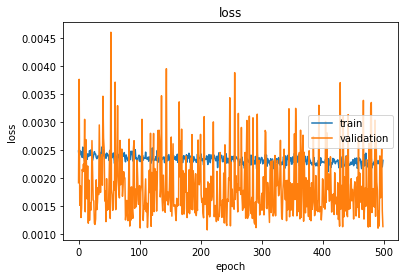

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='center right')
plt.show()

### 畫正確率圖

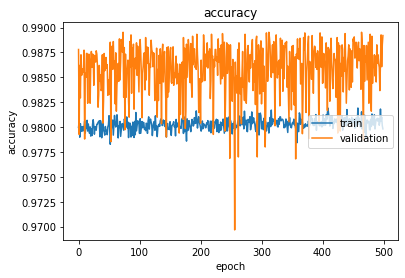

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='center right')
plt.show()

## 測試

In [68]:
y_pred = model.predict(x_test)

error_angles = euclidean_distance(y_test[20, :], y_pred[20, :])
error_points = euclidean_distance(x_test[20, :], dobot_forword_kine(y_pred)[20, :])

print('其中一個解:\n')
print(f'\t角度誤差: {error_angles},\n\t正確解: {y_test[20, :]}\n\t預測解: {y_pred[20, :]}\n')
print(f'\t座標誤差: {error_points},\n\t正確解: {x_test[20, :]}\n\t預測解: {dobot_forword_kine(y_pred)[20, :]}\n')

其中一個解:

	角度誤差: 0.03434463433449872,
	正確解: [ 1.08253173 -0.77503868  0.39726118]
	預測解: [ 1.0788617 -0.7551429  0.3695079]

	座標誤差: 1.9910746525424836,
	正確解: [137.95009422 259.71423546 148.68717397]
	預測解: [139.57774 260.46664 147.82172]



## 儲存與讀取model

In [69]:
# 儲存model爲'model.h5'
filePath = './model.h5'
model.save(filePath)  # 儲存model至'h5_filePath'

# 讀取model
loaded_model = load_model(filePath,
    custom_objects={'euclidean_distance': euclidean_distance})  # 若有設定自訂函數, 需將其加入custom_objects中

In [76]:
from tensorflow.keras.models import load_model

model = load_model(
    "./model.h5", custom_objects={'euclidean_distance': euclidean_distance})

def euclidean_distance(y_true, y_pred):
    return kr.sqrt(kr.sum(kr.square(y_true - y_pred)))

def dobot_ikine_from_DNN(model, x, y, z):
    ik_res = model.predict(np.array([[x, y, z]]), batch_size=500)
    return ik_res

In [78]:
dobot_ik_test = dobot_ikine_from_DNN(model, 200, 0, 100)
print(np.degrees(dobot_ik_test))

[[-6.7681678e-02 -8.4099442e+01  1.0107027e+02]]
